In [ ]:
# prompt: connect to drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:

def scale(arr):
    arr = arr.astype(np.float32)
    if arr.ndim == 4:
        for i in range(len(arr)):
            arr[i,:,:,:] =  (arr[i,:,:,:] - arr[i,:,:,:].min())/ (arr[i,:,:,:].max() - arr[i,:,:,:].min() + 1e-6)
    elif arr.ndim ==3:
        arr[:,:,:] =  (arr[:,:,:] - arr[:,:,:].min())/ (arr[:,:,:].max() - arr[:,:,:].min() + 1e-6)
    else :
        raise Exception("Unknown dimension array provided, expected 3 or 4, got", arr.ndim)
    return arr


def get_RGB(S1, S2):
    blue_c = S1[:,:,:,0] - S1[:,:,:,1]
    blue_c = blue_c[:,:,:,np.newaxis]
    S1_rgb = np.concatenate([S1,blue_c], axis=3)
    S2_rgb = S2[:,:,:,:3]
    return S1_rgb, S2_rgb



def show_preds(S1,S2,S1_pred,S2_pred,epoch, save=True):
    for i in range(len(S1)):
        # plt.figure(figsize=(10,8))
        fig, ax = plt.subplots(nrows=1, ncols=4,figsize= (16,12))
        # plt.subplot(1,4,1)
        ax[0].imshow(scale(S1)[i])
        ax[0].set_title('Original S1')

        ax[1].imshow(scale(S1_pred)[i])
        ax[1].set_title('Generated S1')
        # plt.subplot(1,4,2)
        ax[2].imshow(scale(S2_pred)[i])
        ax[2].set_title('Generated S2')
        # plt.subplot(1,4,3)
        ax[3].imshow(scale(S2)[i])
        ax[3].set_title('Original S2')
        # plt.subplot(1,4,4)
        fig.tight_layout()
        #Save this fig
        if save:
            fig.savefig(f"/content/drive/MyDrive/Flood_Monitoring/CycleGAN2/Pred_Epoch{epoch}_{i}.png")
        plt.show()


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Flood_Monitoring/Cloud2Street/chips"
OUT_PATH = "/content/drive/MyDrive/Flood_Monitoring/Cloud2Street/outputs"

In [ ]:
cloud2Street_data = torch.load(os.path.join(OUT_PATH,"Cloud2Street_dataset.pt"),weights_only=False)
S1_images = cloud2Street_data["S1_images"]
S2_images = cloud2Street_data["S2_images"]
S2_clouds = cloud2Street_data["S2_clouds"]
S2_water = cloud2Street_data["S2_water"]
S1_images.shape, S2_images.shape, S2_water.shape

((900, 512, 512, 2), (900, 512, 512, 4), (900, 512, 512))

In [ ]:
cloud2Street_data.keys()

dict_keys(['S1_images', 'S2_images', 'S2_clouds', 'S2_water', 'S1_paths', 'S2_paths'])

In [ ]:
def NDWI(arr):
    if arr.ndim == 4:
        return (arr[:,:,:,0] - arr[:,:,:,1])/(arr[:,:,:,0] + arr[:,:,:,1] + 1e-6)
    elif arr.ndim ==3:
        return (arr[:,:,0] - arr[:,:,1])/(arr[:,:,0] + arr[:,:,1] + 1e-6)
    else :
        raise Exception("Unknown dimension array provided, expected 3 or 4, got", arr.ndim)

def scale(arr):
    arr = arr.astype(np.float32)
    if arr.ndim == 4:
        for i in range(len(arr)):
            arr[i,:,:,:] =  (arr[i,:,:,:] - arr[i,:,:,:].min())/ (arr[i,:,:,:].max() - arr[i,:,:,:].min() + 1e-6)
    elif arr.ndim ==3:
        arr[:,:,:] =  (arr[:,:,:] - arr[:,:,:].min())/ (arr[:,:,:].max() - arr[:,:,:].min() + 1e-6)
    else :
        raise Exception("Unknown dimension array provided, expected 3 or 4, got", arr.ndim)
    return arr
def tile(im, M, N):
    return np.array([im[x:x+M,y:y+N,:] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)])

In [ ]:
# S2_NDWI = NDWI(scale(S2_images[:,:,:,1]),scale(S2_images[:,:,:,3]))[:,:,:,None]
S2_NDWI = scale(S2_images[:,:,:,[1,3]])

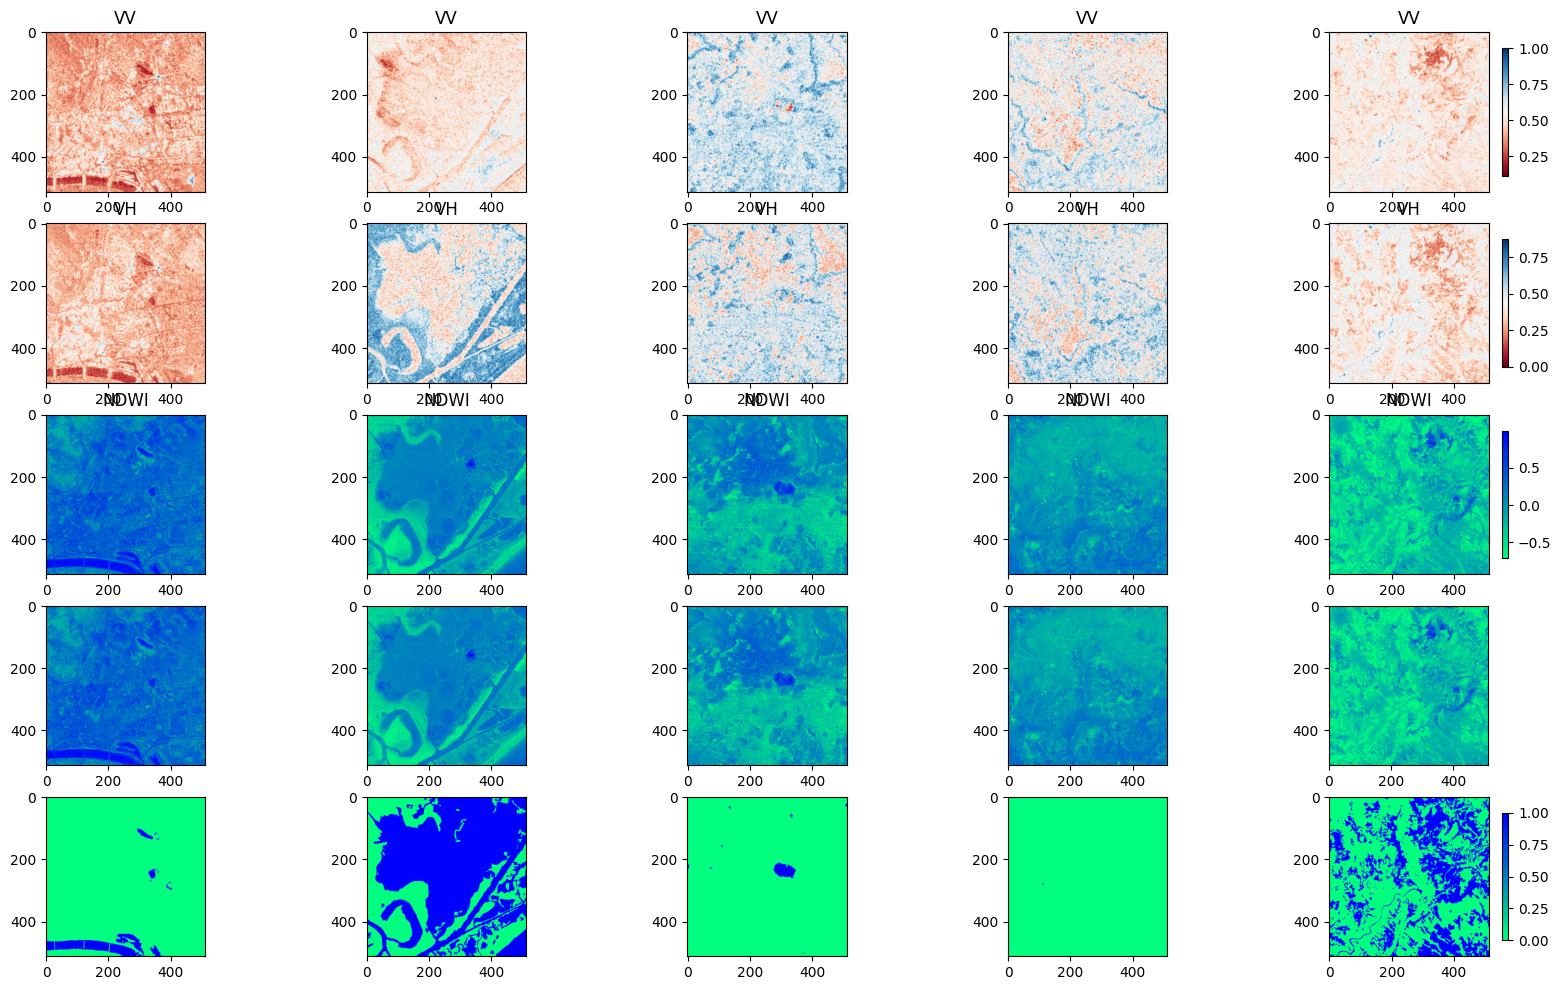

In [ ]:
n_samples = np.random.choice(S1_images.shape[0], 5, replace=False)
fig, ax = plt.subplots(nrows=5, ncols=5,figsize=(20,12))

for i in range(len(n_samples)):
    c1 = ax[0,i].imshow(scale(S1_images[n_samples[i]])[:,:,0],cmap="RdBu")
    c2 = ax[1,i].imshow(scale(S1_images[n_samples[i]])[:,:,1],cmap="RdBu")
    c3 = ax[2,i].imshow(NDWI(S2_NDWI[n_samples[i]]) ,cmap="winter_r")
    # ax[3,i].imshow(scale(S2_images[n_samples[i],:,:,:3]))
    ax[3,i].imshow(scale(NDWI(S2_NDWI[n_samples[i]][:,:,None])) ,cmap="winter_r")
    c4 = ax[4,i].imshow(S2_water[n_samples[i]],cmap="winter_r")

    ax[0,i].set_title("VV")
    ax[1,i].set_title("VH")
    ax[2,i].set_title("NDWI")
plt.colorbar(c1,ax = ax[0,4],shrink = 0.8)
plt.colorbar(c2,ax = ax[1,4],shrink = 0.8)
plt.colorbar(c3,ax = ax[2,4],shrink = 0.8)
plt.colorbar(c4,ax = ax[4,4],shrink = 0.8);

In [ ]:
tile_size = 128
S1_tiles = [tile(im, tile_size, tile_size) for im in S1_images]
S2_tiles = [tile(im, tile_size, tile_size) for im in S2_NDWI]
S2_cloud_tiles = [tile(im, tile_size, tile_size) for im in S2_clouds[:,:,:,None]]
S1_tiles = np.vstack(S1_tiles)
S2_tiles = np.vstack(S2_tiles)
S2_cloud_tiles = np.vstack(S2_cloud_tiles)
cloud_PCT = (S2_cloud_tiles.sum(axis=(1,2))/(tile_size* tile_size)).squeeze()

In [ ]:
import numpy as np
from skimage.filters import threshold_otsu

def ndwi_to_binary(ndwi_array):
    """
    Convert NDWI array to a binary mask using Otsu's thresholding method.

    Parameters:
    ndwi_array (numpy.ndarray): The NDWI array.

    Returns:
    numpy.ndarray: Binary mask based on the optimal threshold.
    """
    # Ensure the NDWI array is scaled between 0 and 1
    ndwi_scaled = (ndwi_array - ndwi_array.min()) / (ndwi_array.max() - ndwi_array.min())

    # Compute the optimal threshold using Otsu's method
    optimal_threshold = threshold_otsu(ndwi_scaled)

    # Create a binary mask based on the threshold
    binary_mask = ndwi_scaled > optimal_threshold

    return binary_mask

In [ ]:
S1_filtered = S1_tiles[cloud_PCT == 0]
S2_filtered = S2_tiles[cloud_PCT == 0]
S1_filtered.shape, S2_filtered.shape

S1_filtered = scale(S1_filtered)
S2_filtered = ndwi_to_binary(scale(NDWI(scale(S2_filtered)))).astype(np.uint8)[:,:,:,None]

S1_train, S1_test, S2_train, S2_test = train_test_split(S1_filtered, S2_filtered, test_size=0.2, random_state=47)

# S1_train  = np.array([tf.cast((img*2) - 1.0, tf.float32) for img in S1_train])
# S2_train  = np.array([tf.cast((img*2) - 1.0, tf.float32) for img in S2_train])

dataset = [S1_train, S2_train]

In [ ]:
S1_cloud = S1_tiles[cloud_PCT == 1]
S2_cloud = S2_tiles[cloud_PCT == 1]

In [ ]:
S1_cloud = scale(S1_cloud)
S2_cloud = ndwi_to_binary(scale(NDWI(scale(S2_cloud)))).astype(np.uint8)[:,:,:,None]

In [ ]:
# for i in range(20):
#   plt.imshow(S2_cloud[i], cmap="winter_r")
#   plt.show()

In [ ]:
S1_filtered.shape, S2_filtered.shape

((7878, 128, 128, 2), (7878, 128, 128, 1))

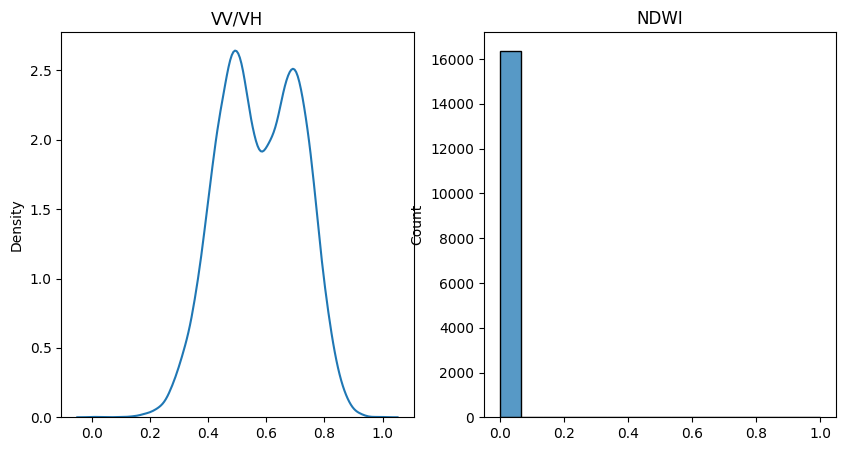

In [ ]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
sns.kdeplot(S1_train[10].flatten(),ax=ax[0]).set_title("VV/VH")
sns.histplot(S2_train[10].flatten(),ax=ax[1]).set_title("NDWI");

In [ ]:
# sample_idx = np.random.randint(0,S1_train.shape[0],5)
# gen_out = g(S1_train[sample_idx])
# gen_out = gen_out.numpy()

# fig, ax = plt.subplots(nrows=4, ncols=5,figsize=(20,12))
# for i,j in enumerate(sample_idx):
#     c1 = ax[0,i].imshow(scale(S1_train[j])[:,:,0],cmap="RdBu")
#     c2 = ax[1,i].imshow(scale(S1_train[j])[:,:,1],cmap="RdBu")
#     c3 = ax[2,i].imshow(scale(NDWI(scale(S2_train[j]))[:,:,None]),cmap="winter_r")
#     c4 = ax[3,i].imshow(scale(NDWI(scale(gen_out[i]))[:,:,None]),cmap="winter_r")
#     ax[0,i].set_title("VV")
#     ax[1,i].set_title("VH")
#     ax[2,i].set_title("NDWI")
#     ax[3,i].set_title("Generated NDWI")
#     ax[0,i].axis("off")
#     ax[1,i].axis("off")
#     ax[2,i].axis("off")
#     ax[3,i].axis("off")
# plt.colorbar(c1,ax = ax[0,4],shrink = 0.8)
# plt.colorbar(c2,ax = ax[1,4],shrink = 0.8)
# plt.colorbar(c3,ax = ax[2,4],shrink = 0.8)
# plt.colorbar(c4,ax = ax[3,4],shrink = 0.8);
# fig.savefig(f"/content/drive/MyDrive/SrJ/Flood_Monitoring/CycleGAN2/Sample_Epoch100000_NoThresh.png")

#Trying UNet


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

In [ ]:
S1_train, S2_train = augment(S1_train, S2_train)

In [ ]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [ ]:

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

In [ ]:

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [ ]:

def build_unet_model():
   # inputs
   inputs = layers.Input(shape=(128,128,2))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(1, 3, padding="same", activation = "sigmoid", kernel_initializer="he_normal")(u9)
#    outputs = u9
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
S1_train.shape, S2_train.shape, S1_test.shape, S2_test.shape

(TensorShape([6302, 128, 128, 2]),
 TensorShape([6302, 128, 128, 1]),
 (1576, 128, 128, 2),
 (1576, 128, 128, 1))

In [ ]:
# import tensorflow as tf
# from tensorflow.keras import backend as K

# def r2_score(y_true, y_pred):
#     ss_res = K.sum(K.square(y_true - y_pred))
#     ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
#     return 1 - ss_res / (ss_tot + K.epsilon())


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def r2_score(y_true, y_pred):
    # cast y_true to the dtype of y_pred (typically float32)
    y_true = tf.cast(y_true, dtype=y_pred.dtype)
    # residual sum of squares
    ss_res = K.sum(K.square(y_true - y_pred))
    # total sum of squares
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())


In [ ]:
import tensorflow as tf

@tf.keras.utils.register_keras_serializable()
class GroupNormalization(tf.keras.layers.Layer):
    def __init__(self, groups=8, axis=-1, epsilon=1e-5, **kwargs):
        super(GroupNormalization, self).__init__(**kwargs)
        self.groups = groups
        self.axis = axis
        self.epsilon = epsilon

    def build(self, input_shape):
        dim = input_shape[self.axis]
        if dim is None:
            raise ValueError(f"Axis {self.axis} of input tensor should be defined.")
        if dim % self.groups != 0:
            raise ValueError(f"Number of groups ({self.groups}) must divide number of channels ({dim}).")
        self.gamma = self.add_weight(shape=(dim,), initializer="ones", trainable=True)
        self.beta = self.add_weight(shape=(dim,), initializer="zeros", trainable=True)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        N, H, W, C = input_shape[0], input_shape[1], input_shape[2], input_shape[3]
        G = self.groups
        x = tf.reshape(inputs, [N, H, W, G, C // G])
        mean, var = tf.nn.moments(x, [1, 2, 4], keepdims=True)
        x = (x - mean) / tf.sqrt(var + self.epsilon)
        x = tf.reshape(x, [N, H, W, C])
        return self.gamma * x + self.beta

    def get_config(self):
        config = super().get_config()
        config.update({
            "groups": self.groups,
            "axis": self.axis,
            "epsilon": self.epsilon,
        })
        return config


In [ ]:

import tensorflow as tf
from tensorflow.keras import layers

def double_conv_block(x, filters, groups=8):
    x = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(x)
    x = GroupNormalization(groups=groups)(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(x)
    x = GroupNormalization(groups=groups)(x)
    x = layers.ReLU()(x)

    return x


def downsample_block(x, filters, groups=8):
    f = double_conv_block(x, filters, groups=groups)
    p = layers.MaxPooling2D((2, 2))(f)
    return f, p

def upsample_block(x, skip, filters, groups=8):
    x = layers.Conv2DTranspose(filters, 2, strides=(2, 2), padding="same")(x)
    if skip is not None:
        x = layers.Concatenate()([x, skip])
    x = double_conv_block(x, filters, groups=groups)
    return x

def build_unet_model(depth=4, input_shape=(128, 128, 2), output_channels=1, groups=8):
    inputs = layers.Input(shape=input_shape)

    # Downsampling
    skips = []
    x = inputs
    filters = 64
    for _ in range(depth):
        f, x = downsample_block(x, filters, groups=groups)
        skips.append(f)
        filters *= 2

    # Bottleneck
    x = double_conv_block(x, filters, groups=groups)

    # Upsampling
    for f in reversed(skips):
        filters //= 2
        x = upsample_block(x, f, filters, groups=groups)

    # Output
    outputs = layers.Conv2D(output_channels, 3, padding="same", activation="sigmoid")(x)
    model = tf.keras.Model(inputs, outputs, name=f"U-Net_depth{depth}_groupnorm")
    return model


In [ ]:
# unet_model.save("unet_model.keras")
# from tensorflow import keras

# unet_model = keras.models.load_model(os.path.join(OUT_PATH,"U-Net",f"best_model_unet__depth_{depth}_groups_{groups}.keras"), custom_objects={'r2_score': r2_score})


In [ ]:
# def iou_loss(y_true, y_pred):
#     y_true = tf.cast(y_true, dtype=tf.float32)
#     y_pred = tf.cast(y_pred, dtype=tf.float32)

#     intersection = K.sum(y_true * y_pred)
#     sum_ = K.sum(y_true + y_pred)
#     jac = (intersection + 1.0) / (sum_ - intersection + 1.0)
#     return 1 - jac

# unet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=iou_loss,
#                    metrics=['accuracy', tf.keras.metrics.AUC(), r2_score])


In [ ]:
EPOCHS = 100
BATCH_SIZE = 64
STEPS_PER_BATCH = len(S1_train) // BATCH_SIZE
VAL_STEPS = len(S1_test) // BATCH_SIZE

In [ ]:
# # before you do any model.fit(...)
# S1_train = S1_train.astype("float32")
# S1_test  = S1_test.astype("float32")
# S2_train = S2_train.astype("float32")
# S2_test  = S2_test.astype("float32")


In [ ]:
# history = unet_model.fit(
#     x=S1_train,
#     y=S2_train,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     validation_data=(S1_test, S2_test),
#     callbacks=[checkpoint]
# )


In [ ]:
# from tensorflow.keras.models import load_model
# #  Load the model with the custom object
# unet_model = load_model(os.path.join(OUT_PATH,"U-Net",f"best_model_unet__depth_{depth}_groups_{groups}.keras") )


In [ ]:
# Build a U-Net with depth 4 and GroupNorm with 8 groups
depth=3
groups=2
unet_model = build_unet_model(depth=depth, groups=groups)
# unet_model.summary()

unet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="binary_crossentropy",
                   metrics=['accuracy', keras.metrics.AUC(),r2_score,tf.keras.metrics.MeanIoU(num_classes=2)])            #,tf.keras.metrics.MeanIoU(num_classes=2)])
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint(os.path.join(OUT_PATH,"U-Net",f"best_model_unet__depth_{depth}_groups_{groups}.keras"), monitor='val_loss', verbose=0,
    save_best_only=True, mode='auto')
# unet_model= keras.models.load_model(os.path.join(OUT_PATH,"U-Net",f"best_model_unet__depth_{depth}_groups_{groups}.keras"), custom_objects={'r2_score': r2_score})
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history = unet_model.fit(S1_train, S2_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          validation_data=(S1_test, S2_test), callbacks=[checkpoint,early_stop],
                        #  sample_weight = {0:1, 1:2}
                         )

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 110s 922ms/step - accuracy: 0.7994 - auc_11: 0.5522 - loss: 0.4842 - mean_io_u_11: 0.4178 - r2_score: -0.1521 - val_accuracy: 0.8247 - val_auc_11: 0.6961 - val_loss: 0.4404 - val_mean_io_u_11: 0.4124 - val_r2_score: 0.0378
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 78s 786ms/step - accuracy: 0.8273 - auc_11: 0.6790 - loss: 0.4311 - mean_io_u_11: 0.4131 - r2_score: 0.0590 - val_accuracy: 0.8274 - val_auc_11: 0.6307 - val_loss: 0.4410 - val_mean_io_u_11: 0.4124 - val_r2_score: 0.0718
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 77s 783ms/step - accuracy: 0.8446 - auc_11: 0.7289 - loss: 0.3944 - mean_io_u_11: 0.4144 - r2_score: 0.1530 - val_accuracy: 0.8588 - val_auc_11: 0.7949 - val_loss: 0.3743 - val_mean_io_u_11: 0.4124 - val_r2_score: 0.2148
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 77s 783ms/step - accuracy: 0.8709 - auc_11: 0.7937 - loss: 0.3482 - mean_io_u_11: 0.4158 - r2_score: 0.2574 - val_accuracy: 0.8809 - val_auc_11: 0.8249 - val_loss: 0.3295 - val_me

In [ ]:
import os
import re
import tensorflow as tf
import pandas as pd
from tensorflow import keras

# # Path setup
# OUT_PATH = "/your/output/path"

# # Custom metric
# def r2_score(y_true, y_pred):
#     SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
#     SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
#     return 1 - SS_res/(SS_tot + tf.keras.backend.epsilon())

# Your datasets
# S1_train, S2_train, S1_test, S2_test are already defined

# Regex to extract depth and groups
pattern = r"best_model_unet__depth_(\d+)_groups_(\d+).keras"

# List all models
model_folder = os.path.join(OUT_PATH, "U-Net")
model_files = [f for f in os.listdir(model_folder) if f.endswith(".keras")]

# Store results
results = []

# Loop over models
for model_file in model_files:
    match = re.search(pattern, model_file)
    if match:
        depth = int(match.group(1))
        groups = int(match.group(2))

        print(f"\n🔹 Evaluating model: depth={depth}, groups={groups}")

        # Load the model safely
        model_path = os.path.join(model_folder, model_file)
        try:
            model = keras.models.load_model(model_path, custom_objects={'r2_score': r2_score})
        except Exception as e:
            print(f"❌ Failed to load {model_file}: {e}")
            continue  # skip to next model

        # Compile (required before evaluate)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(1e-4),
            loss="binary_crossentropy",
            metrics=[
                'accuracy',
                keras.metrics.AUC(),
                r2_score,
                tf.keras.metrics.MeanIoU(num_classes=2)
            ]
        )

        # Evaluate on train
        train_metrics = model.evaluate(S1_train, S2_train, verbose=0)

        # Evaluate on test
        test_metrics = model.evaluate(S1_test, S2_test, verbose=0)

        # Save results
        results.append({
            "Depth": depth,
            "Groups": groups,
            "Train Loss": train_metrics[0],
            "Train Accuracy": train_metrics[1],
            "Train AUC": train_metrics[2],
            "Train R2": train_metrics[3],
            "Train Mean IoU": train_metrics[4],
            "Test Loss": test_metrics[0],
            "Test Accuracy": test_metrics[1],
            "Test AUC": test_metrics[2],
            "Test R2": test_metrics[3],
            "Test Mean IoU": test_metrics[4],
        })
    else:
        print(f"⚠️ Skipped filename format: {model_file}")

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Sort by Depth, then Groups (optional)
results_df = results_df.sort_values(by=["Depth", "Groups"])

# Display table
print(results_df)

# # Save as LaTeX
# latex_table = results_df.to_latex(index=False, float_format="%.4f")
# with open("model_evaluation_results.tex", "w") as f:
#     f.write(latex_table)

# print("\n✅ LaTeX table saved as model_evaluation_results.tex")


⚠️ Skipped filename format: unet_epoch20.keras
⚠️ Skipped filename format: unet_epoch40.keras
⚠️ Skipped filename format: unet_epoch_mutli_threshold_40.keras
⚠️ Skipped filename format: best_model_unet_mutli_threshold.keras
⚠️ Skipped filename format: best_model_unet_mutli_threshold_5.keras

🔹 Evaluating model: depth=4, groups=32
❌ Failed to load best_model_unet__depth_4_groups_32.keras: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 9.999999747378752e-05, 'weight_decay': None, 'clipn

In [ ]:
temp_vit=Vit

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.models import Model

import tensorflow as tf
from tensorflow.keras import layers

@tf.keras.utils.register_keras_serializable()
class PatchEmbedding(layers.Layer):
    """
    Splits the input image into non-overlapping patches and projects each
    patch to a vector of dimension `embed_dim`.
    """

    def __init__(self, patch_size=16, embed_dim=768, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        self.projection = layers.Conv2D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="valid",
            kernel_initializer="he_normal"
        )

    def build(self, input_shape):
        _, H, W, _ = input_shape
        if H % self.patch_size != 0 or W % self.patch_size != 0:
            raise ValueError(
                f"Input spatial dimensions ({H}, {W}) must be divisible by patch_size={self.patch_size}"
            )
        self.num_patches = (H // self.patch_size) * (W // self.patch_size)

        # Important: manually build inner Conv2D layer
        self.projection.build(input_shape)

        super().build(input_shape)

    def call(self, x):
        x = self.projection(x)
        x = tf.reshape(x, [-1, self.num_patches, self.embed_dim])
        return x

    def compute_output_shape(self, input_shape):
        batch, H, W, _ = input_shape
        npatches = (H // self.patch_size) * (W // self.patch_size)
        return (batch, npatches, self.embed_dim)

    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
            "embed_dim": self.embed_dim,
        })
        return config

# Transformer encoder block
def transformer_encoder(x, embed_dim, num_heads=8, mlp_dim=2048, dropout_rate=0.1):
    # Layer norm + Multi-head self-attention
    x1 = LayerNormalization(epsilon=1e-6)(x)
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x1, x1)
    x2 = layers.Add()([attention_output, x])

    # Layer norm + MLP
    x3 = LayerNormalization(epsilon=1e-6)(x2)
    mlp_output = layers.Dense(mlp_dim, activation='gelu')(x3)
    mlp_output = layers.Dense(embed_dim)(mlp_output)
    x_out = layers.Add()([mlp_output, x2])

    return x_out

import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.models import Model

# … (PatchEmbedding and transformer_encoder unchanged) …

def build_vit_model(
    input_shape=(128, 128, 2),
    patch_size=16,
    embed_dim=256,
    depth=8,
    num_heads=8,
    mlp_dim=512,
    output_channels=1
):
    inputs = layers.Input(shape=input_shape)

    # Patch → tokens
    x = PatchEmbedding(patch_size=patch_size, embed_dim=embed_dim)(inputs)

    # Learnable pos emb
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    pos_emb = tf.Variable(tf.random.normal([1, num_patches, embed_dim]), trainable=True)
    x = x + pos_emb

    # Transformer stack
    for _ in range(depth):
        x = transformer_encoder(x, embed_dim, num_heads=num_heads, mlp_dim=mlp_dim)

    # Back to 4D
    h = input_shape[0] // patch_size
    w = input_shape[1] // patch_size
    x = layers.Reshape((h, w, embed_dim))(x)

    # Upsample back to 128×128 dynamically
    # need log2(patch_size) upsampling steps at stride=2
    up_steps = int(math.log2(patch_size))
    filters = embed_dim
    for _ in range(up_steps):
        filters //= 2
        x = layers.Conv2DTranspose(filters,
                                   kernel_size=3,
                                   strides=2,
                                   padding="same",
                                   activation="relu")(x)

    # Final 1×1 conv to get your output channels
    outputs = layers.Conv2D(output_channels,
                            kernel_size=1,
                            padding="same",
                            activation="sigmoid")(x)

    return Model(inputs, outputs, name="VisionTransformer")

# Usage
depth = 8
Vit = build_vit_model(depth=depth)

Vit.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.AUC(),
        r2_score,
        tf.keras.metrics.MeanIoU(num_classes=2)
    ]
)
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_vit = ModelCheckpoint(os.path.join(OUT_PATH,"U-Net",f"best_model_vit__depth_{depth}.keras"), monitor='val_loss', verbose=0,
    save_best_only=True, mode='auto')
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history = Vit.fit(S1_train, S2_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          validation_data=(S1_test, S2_test), callbacks=[checkpoint_vit,early_stop],
                        #  sample_weight = {0:1, 1:2}
                         )



Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 85s 514ms/step - accuracy: 0.7982 - auc_30: 0.4839 - loss: 0.5389 - mean_io_u_30: 0.4189 - r2_score: -0.4337 - val_accuracy: 0.8247 - val_auc_30: 0.5428 - val_loss: 0.4644 - val_mean_io_u_30: 0.4124 - val_r2_score: -0.0180
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 32s 324ms/step - accuracy: 0.8250 - auc_30: 0.5204 - loss: 0.4656 - mean_io_u_30: 0.4125 - r2_score: -0.0164 - val_accuracy: 0.8247 - val_auc_30: 0.6035 - val_loss: 0.4618 - val_mean_io_u_30: 0.4124 - val_r2_score: -0.0125
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 32s 328ms/step - accuracy: 0.8281 - auc_30: 0.5225 - loss: 0.4602 - mean_io_u_30: 0.4140 - r2_score: -0.0310 - val_accuracy: 0.8250 - val_auc_30: 0.6615 - val_loss: 0.4324 - val_mean_io_u_30: 0.4124 - val_r2_score: 0.0680
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 30s 305ms/step - accuracy: 0.8303 - auc_30: 0.6078 - loss: 0.4350 - mean_io_u_30: 0.4151 - r2_score: 0.0454 - val_accuracy: 0.8250 - val_auc_30: 0.6658 - val_loss: 0.4408 - val

In [ ]:
Vit=keras.models.load_model(os.path.join(OUT_PATH,"U-Net",f"best_model_vit__depth_{depth}.keras"),custom_objects={'r2_score': r2_score})

train_metrics = Vit.evaluate(S1_train, S2_train, verbose=0)

# Evaluate on test
test_metrics = Vit.evaluate(S1_test, S2_test, verbose=0)

In [ ]:
# Save results
{
    "Depth": depth,
    # "Groups": groups,
    "Train Loss": train_metrics[0],
    "Train Accuracy": train_metrics[1],
    "Train AUC": train_metrics[2],
    "Train R2": train_metrics[3],
    "Train Mean IoU": train_metrics[4],
    "Test Loss": test_metrics[0],
    "Test Accuracy": test_metrics[1],
    "Test AUC": test_metrics[2],
    "Test R2": test_metrics[3],
    "Test Mean IoU": test_metrics[4],
}

{'Depth': 8,
 'Train Loss': 0.22242532670497894,
 'Train Accuracy': 0.9256001114845276,
 'Train AUC': 0.9082462787628174,
 'Train R2': 0.5376788377761841,
 'Train Mean IoU': 0.4149589538574219,
 'Test Loss': 0.2681800425052643,
 'Test Accuracy': 0.9103865027427673,
 'Test AUC': 0.8661543130874634,
 'Test R2': 0.4650614261627197,
 'Test Mean IoU': 0.41236233711242676}

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math

# ---------------------------------------------------
# 1) Overlap Patch Embedding (hierarchical)
# ---------------------------------------------------
import tensorflow as tf
from tensorflow.keras import layers

@tf.keras.utils.register_keras_serializable()
class OverlapPatchEmbed(layers.Layer):
    def __init__(self, embed_dim, kernel_size=7, stride=4, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.kernel_size = kernel_size
        self.stride = stride

        self.proj = layers.Conv2D(
            embed_dim,
            kernel_size=kernel_size,
            strides=stride,
            padding="same",
            kernel_initializer="he_normal"
        )
        self.norm = layers.LayerNormalization(epsilon=1e-6)

    def build(self, input_shape):
        # Nothing special needed here because Conv2D and LayerNorm will build automatically
        super().build(input_shape)

    def call(self, x):
        x = self.proj(x)                # [B, H/stride, W/stride, embed_dim]
        b, h, w, c = tf.unstack(tf.shape(x))
        x = tf.reshape(x, [b, h * w, c])  # flatten spatial dimensions
        x = self.norm(x)
        x = tf.reshape(x, [b, h, w, c])   # reshape back
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "kernel_size": self.kernel_size,
            "stride": self.stride,
        })
        return config


# ---------------------------------------------------
# 2) Transformer Block (same as before but on 2D)
# ---------------------------------------------------
def transformer_block(x, embed_dim, num_heads, mlp_ratio=4, dropout=0.0):
    b, h, w, c = tf.unstack(tf.shape(x))
    # flatten for attention
    x_flat = tf.reshape(x, [b, h*w, c])
    x1 = layers.LayerNormalization(epsilon=1e-6)(x_flat)
    attn = layers.MultiHeadAttention(num_heads=num_heads,
                                     key_dim=embed_dim//num_heads,
                                     dropout=dropout)(x1, x1)
    x2 = x_flat + attn

    # MLP / Mix-FFN
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    mlp_hidden = int(embed_dim * mlp_ratio)
    mlp = layers.Dense(mlp_hidden, activation="gelu")(x3)
    mlp = layers.Dense(embed_dim)(mlp)
    x4 = x2 + mlp

    # reshape back to 2D
    x_out = tf.reshape(x4, [b, h, w, c])
    return x_out

# ---------------------------------------------------
# 3) Build SegFormer
# ---------------------------------------------------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def build_segformer(
    input_shape=(128,128,2),
    num_classes=1,
    embed_dims=[64,128,256,512],
    depths=[2,2,2,2],
    num_heads=[1,2,4,8],
    mlp_ratio=4
):
    # 1) precompute each stage’s (H, W)
    strides = [4,2,2,2]
    Hs = []; Ws = []
    h, w = input_shape[0], input_shape[1]
    for s in strides:
        h //= s; w //= s
        Hs.append(h); Ws.append(w)

    inputs = layers.Input(input_shape)
    x = inputs
    features = []

    # 2) Encoder (same as before) …
    for i in range(4):
        # OverlapPatchEmbed
        kernel = 7 if i==0 else 3
        x = layers.Conv2D(embed_dims[i], kernel_size=kernel, strides=strides[i],
                          padding="same", kernel_initializer="he_normal")(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Transformer blocks…
        for _ in range(depths[i]):
            seq = layers.Reshape((Hs[i]*Ws[i], embed_dims[i]))(x)
            y = layers.LayerNormalization(epsilon=1e-6)(seq)
            y = layers.MultiHeadAttention(
                    num_heads=num_heads[i],
                    key_dim=embed_dims[i]//num_heads[i]
                )(y, y)
            seq = layers.Add()([seq, y])
            y = layers.LayerNormalization(epsilon=1e-6)(seq)
            y = layers.Dense(embed_dims[i]*mlp_ratio, activation="gelu")(y)
            y = layers.Dense(embed_dims[i])(y)
            seq = layers.Add()([seq, y])
            x = layers.Reshape((Hs[i], Ws[i], embed_dims[i]))(seq)

        features.append(x)

    # 3) Decoder: upsample each feature *all the way* to 128×128
    ups = []
    for i, feat in enumerate(features):
        # unify channels
        y = layers.Conv2D(embed_dims[0], 1, padding="same")(feat)
        # compute scale to original size
        scale_h = input_shape[0] // Hs[i]
        scale_w = input_shape[1] // Ws[i]
        y = layers.UpSampling2D((scale_h, scale_w), interpolation="bilinear")(y)
        ups.append(y)

    x = layers.Concatenate()(ups)
    x = layers.Conv2D(embed_dims[0], 3, padding="same", activation="gelu")(x)
    x = layers.Conv2D(embed_dims[0], 3, padding="same", activation="gelu")(x)

    # 4) now x is (None,128,128,embed_dims[0]) → segmentation head
    outputs = layers.Conv2D(num_classes, 1, padding="same", activation="sigmoid")(x)

    return keras.Model(inputs, outputs, name="SegFormer")


# --- Usage example
SEG = build_segformer(
    input_shape=(128,128,2),
    num_classes=1,
    embed_dims=[64,128,256,512],
    depths=[2,2,2,2],
    num_heads=[1,2,4,8]
)

SEG.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.AUC(),
        r2_score,
        tf.keras.metrics.MeanIoU(num_classes=2)
    ]
)

# SEG.summary()


# SEG.summary()
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_SEG = ModelCheckpoint(os.path.join(OUT_PATH,"U-Net",f"best_model_SEG.keras"), monitor='val_loss', verbose=0,
    save_best_only=True, mode='auto')
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history = SEG.fit(S1_train, S2_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          validation_data=(S1_test, S2_test), callbacks=[checkpoint_SEG,early_stop],
                        #  sample_weight = {0:1, 1:2}
                         )


Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.7906 - auc_1: 0.5143 - loss: 0.5142 - mean_io_u_1: 0.4171 - r2_score: -0.2351 - val_accuracy: 0.8268 - val_auc_1: 0.6510 - val_loss: 0.4393 - val_mean_io_u_1: 0.4124 - val_r2_score: 0.0470
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 66s 669ms/step - accuracy: 0.8325 - auc_1: 0.5772 - loss: 0.4528 - mean_io_u_1: 0.4149 - r2_score: 0.0041 - val_accuracy: 0.8375 - val_auc_1: 0.6611 - val_loss: 0.4243 - val_mean_io_u_1: 0.4124 - val_r2_score: 0.0907
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 66s 665ms/step - accuracy: 0.8404 - auc_1: 0.6077 - loss: 0.4316 - mean_io_u_1: 0.4144 - r2_score: 0.0618 - val_accuracy: 0.8385 - val_auc_1: 0.6781 - val_loss: 0.4199 - val_mean_io_u_1: 0.4124 - val_r2_score: 0.1015
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 65s 654ms/step - accuracy: 0.8383 - auc_1: 0.6396 - loss: 0.4273 - mean_io_u_1: 0.4129 - r2_score: 0.0710 - val_accuracy: 0.8302 - val_auc_1: 0.5904 - val_loss: 0.4486 - val_mean_io_u_1: 0.4124 

In [ ]:
SEG=keras.models.load_model(os.path.join(OUT_PATH,"U-Net",f"best_model_SEG.keras"),custom_objects={'r2_score': r2_score})

train_metrics = SEG.evaluate(S1_train, S2_train, verbose=0)

# Evaluate on test
test_metrics = SEG.evaluate(S1_test, S2_test, verbose=0)

In [ ]:
# Save results
{
    # "Depth": depth,
    # "Groups": groups,
    "Train Loss": train_metrics[0],
    "Train Accuracy": train_metrics[1],
    "Train AUC": train_metrics[2],
    "Train R2": train_metrics[3],
    "Train Mean IoU": train_metrics[4],
    "Test Loss": test_metrics[0],
    "Test Accuracy": test_metrics[1],
    "Test AUC": test_metrics[2],
    "Test R2": test_metrics[3],
    "Test Mean IoU": test_metrics[4],
}

{'Train Loss': 0.2032526284456253,
 'Train Accuracy': 0.9310990571975708,
 'Train AUC': 0.9307910203933716,
 'Train R2': 0.5651093125343323,
 'Train Mean IoU': 0.4149589538574219,
 'Test Loss': 0.2917996048927307,
 'Test Accuracy': 0.8999893069267273,
 'Test AUC': 0.8572912216186523,
 'Test R2': 0.3731726109981537,
 'Test Mean IoU': 0.41236233711242676}

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, Model, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# ──────────────────────────────────────────────────────────────────────────────
# 1) GroupNormalization
# ──────────────────────────────────────────────────────────────────────────────
@tf.keras.utils.register_keras_serializable()
class GroupNormalization(layers.Layer):
    def __init__(self, groups=8, axis=-1, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.groups = groups
        self.axis = axis
        self.epsilon = epsilon

    def build(self, input_shape):
        dim = input_shape[self.axis]
        if dim is None:
            raise ValueError(f"Axis {self.axis} must be defined.")
        if dim % self.groups != 0:
            raise ValueError(f"{dim} channels not divisible by {self.groups} groups.")
        self.gamma = self.add_weight(shape=(dim,), initializer="ones", trainable=True)
        self.beta  = self.add_weight(shape=(dim,), initializer="zeros", trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        # reshape to [N, H, W, G, C//G]
        N, H, W, C = tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[2], tf.shape(inputs)[3]
        G = self.groups
        x = tf.reshape(inputs, [N, H, W, G, C // G])
        mean, var = tf.nn.moments(x, [1,2,4], keepdims=True)
        x = (x - mean) / tf.sqrt(var + self.epsilon)
        x = tf.reshape(x, [N, H, W, C])
        return self.gamma * x + self.beta

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"groups": self.groups, "axis": self.axis, "epsilon": self.epsilon})
        return cfg

# ──────────────────────────────────────────────────────────────────────────────
# 2) Double‐Conv block (U-Net style)
# ──────────────────────────────────────────────────────────────────────────────
def double_conv_block(x, filters, groups=8):
    x = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(x)
    x = GroupNormalization(groups=groups)(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(x)
    x = GroupNormalization(groups=groups)(x)
    return layers.ReLU()(x)

# ──────────────────────────────────────────────────────────────────────────────
# 3) WindowAttention
# ──────────────────────────────────────────────────────────────────────────────
@tf.keras.utils.register_keras_serializable()
class WindowAttention(layers.Layer):
    def __init__(self, dim, num_heads, window_size=4, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.attn = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=dim // num_heads
        )

    def build(self, input_shape):
        # input_shape = (batch, H, W, C)
        _, H, W, C = input_shape
        if H is None or W is None:
            raise ValueError("WindowAttention requires known H, W at build time.")
        if (H % self.window_size) or (W % self.window_size):
            raise ValueError(f"H/W ({H},{W}) must be divisible by window_size={self.window_size}")
        # build the MHA on one window sequence: query and value shapes the same
        window_seq_shape = (None, self.window_size * self.window_size, C)
        self.attn.build(query_shape=window_seq_shape, value_shape=window_seq_shape)
        super().build(input_shape)

    def call(self, x):
        B, H, W, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
        ws = self.window_size

        # partition into windows
        x = tf.reshape(x, [B, H//ws, ws, W//ws, ws, C])
        x = tf.transpose(x, [0,1,3,2,4,5])                     # [B, nH, nW, ws, ws, C]
        windows = tf.reshape(x, [-1, ws*ws, C])                # [B*nH*nW, ws*ws, C]

        # self-attend
        attn_out = self.attn(windows, windows)

        # merge back
        attn_out = tf.reshape(attn_out, [B, H//ws, W//ws, ws, ws, C])
        attn_out = tf.transpose(attn_out, [0,1,3,2,4,5])
        return tf.reshape(attn_out, [B, H, W, C])

    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            "dim": self.dim,
            "num_heads": self.num_heads,
            "window_size": self.window_size,
        })
        return cfg


# ──────────────────────────────────────────────────────────────────────────────
# 4) SwinTransformerBlock
# ──────────────────────────────────────────────────────────────────────────────
@tf.keras.utils.register_keras_serializable()
class SwinTransformerBlock(layers.Layer):
    def __init__(self, dim, num_heads, window_size=4, mlp_ratio=4, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.mlp_ratio = mlp_ratio

        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.attn  = WindowAttention(dim, num_heads, window_size)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp   = Sequential([
            layers.Dense(dim * mlp_ratio, activation="gelu"),
            layers.Dense(dim),
        ])

    def build(self, input_shape):
        self.norm1.build(input_shape)
        self.attn.build(input_shape)
        self.norm2.build(input_shape)
        self.mlp.build(input_shape)
        super().build(input_shape)

    def call(self, x):
        x1 = self.norm1(x)
        a  = self.attn(x1)
        x2 = layers.Add()([x, a])
        x3 = self.norm2(x2)
        m  = self.mlp(x3)
        return layers.Add()([x2, m])

    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            "dim": self.dim,
            "num_heads": self.num_heads,
            "window_size": self.window_size,
            "mlp_ratio": self.mlp_ratio,
        })
        return cfg

# ──────────────────────────────────────────────────────────────────────────────
# 5) Swin-UNet builder
# ──────────────────────────────────────────────────────────────────────────────
def build_swin_unet(
    input_shape=(128,128,2),
    num_classes=1,
    embed_dims=[64,128,256,512],
    depths=[2,2,6,2],
    num_heads=[2,4,8,16],
    window_size=4
):
    inp = Input(input_shape)
    x   = inp
    skips = []

    # Encoder
    for i in range(4):
        stride = 4 if i==0 else 2
        x = layers.Conv2D(embed_dims[i], 3, strides=stride, padding="same")(x)
        for _ in range(depths[i]):
            x = SwinTransformerBlock(embed_dims[i], num_heads[i], window_size)(x)
        skips.append(x)

    # Bottleneck
    x = skips.pop()

    # Decoder
    for i in reversed(range(3)):
        x = layers.Conv2DTranspose(embed_dims[i], 2, strides=2, padding="same")(x)
        x = layers.Concatenate()([x, skips[i]])
        x = double_conv_block(x, embed_dims[i])

    # Final upsample
    x = layers.Conv2DTranspose(embed_dims[0]//2, 4, strides=4, padding="same", activation="relu")(x)
    out = layers.Conv2D(num_classes, 1, padding="same", activation="sigmoid")(x)

    return Model(inp, out, name="SwinUNet")

# ──────────────────────────────────────────────────────────────────────────────
# 6) Instantiate, compile, and set up callbacks
# ──────────────────────────────────────────────────────────────────────────────
Swin = build_swin_unet()

Swin.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.AUC(),
        r2_score,
        tf.keras.metrics.MeanIoU(num_classes=2)
    ]
)

checkpoint_Swin = ModelCheckpoint(
    os.path.join(OUT_PATH, "U-Net", "best_model_Swin.keras"),
    monitor="val_loss", save_best_only=True
)
early_stop = EarlyStopping(monitor="val_loss", patience=10)

# Now you can do:
history = Swin.fit(S1_train, S2_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                  validation_data=(S1_test, S2_test),
                  callbacks=[checkpoint_Swin, early_stop])


Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 142s 761ms/step - accuracy: 0.8002 - auc_5: 0.5254 - loss: 0.5600 - mean_io_u_5: 0.4130 - r2_score: -0.3450 - val_accuracy: 0.8247 - val_auc_5: 0.5812 - val_loss: 0.4594 - val_mean_io_u_5: 0.4124 - val_r2_score: -0.0065
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 36s 364ms/step - accuracy: 0.8355 - auc_5: 0.6281 - loss: 0.4335 - mean_io_u_5: 0.4177 - r2_score: 0.0080 - val_accuracy: 0.8247 - val_auc_5: 0.6748 - val_loss: 0.4364 - val_mean_io_u_5: 0.4124 - val_r2_score: 0.0525
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 35s 352ms/step - accuracy: 0.8394 - auc_5: 0.7113 - loss: 0.4028 - mean_io_u_5: 0.4180 - r2_score: 0.0958 - val_accuracy: 0.8394 - val_auc_5: 0.7288 - val_loss: 0.4025 - val_mean_io_u_5: 0.4124 - val_r2_score: 0.1411
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 35s 352ms/step - accuracy: 0.8560 - auc_5: 0.7481 - loss: 0.3727 - mean_io_u_5: 0.4195 - r2_score: 0.1597 - val_accuracy: 0.8495 - val_auc_5: 0.7567 - val_loss: 0.3898 - val_mean_io_u_5: 0.4

In [ ]:
Swin=keras.models.load_model(os.path.join(OUT_PATH,"U-Net",f"best_model_Swin.keras"),custom_objects={'r2_score': r2_score})

train_metrics = Swin.evaluate(S1_train, S2_train, verbose=0)

# Evaluate on test
test_metrics = Swin.evaluate(S1_test, S2_test, verbose=0)

In [ ]:
# Save results
{
    # "Depth": depth,
    # "Groups": groups,
    "Train Loss": train_metrics[0],
    "Train Accuracy": train_metrics[1],
    "Train AUC": train_metrics[2],
    "Train R2": train_metrics[3],
    "Train Mean IoU": train_metrics[4],
    "Test Loss": test_metrics[0],
    "Test Accuracy": test_metrics[1],
    "Test AUC": test_metrics[2],
    "Test R2": test_metrics[3],
    "Test Mean IoU": test_metrics[4],
}

{'Train Loss': 0.21323469281196594,
 'Train Accuracy': 0.9300222992897034,
 'Train AUC': 0.9110727310180664,
 'Train R2': 0.556086003780365,
 'Train Mean IoU': 0.4149589538574219,
 'Test Loss': 0.23867101967334747,
 'Test Accuracy': 0.921934962272644,
 'Test AUC': 0.8825715780258179,
 'Test R2': 0.5207668542861938,
 'Test Mean IoU': 0.41236233711242676}

In [ ]:
from google.colab import runtime
runtime.unassign()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 K

In [ ]:
unet_model.save(os.path.join(OUT_PATH,"U-Net", "unet_epoch_mutli_threshold_40.keras"))

In [ ]:
!ls /content/drive/MyDrive/Flood_Monitoring/Cloud2Street/outputs/U-Net

In [ ]:
# Define the path to the saved model
model_path = os.path.join(OUT_PATH, "U-Net", "best_model_unet_mutli_threshold.hdf5")

from tensorflow.keras.models import load_model

# Load the model with the custom object
unet_model = load_model(model_path, custom_objects={'r2_score': r2_score})


In [ ]:
S1_test.shape, S2_test.shape

In [ ]:
sample_idx = np.random.randint(0,S1_test.shape[0],5)
mask_out = unet_model(scale(S1_test[sample_idx]))
mask_out = mask_out.numpy()

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=5,figsize=(20,12))
for i,j in enumerate(sample_idx):
    c1 = ax[0,i].imshow(scale(S1_test[j])[:,:,0],cmap="RdBu")
    c2 = ax[1,i].imshow(scale(S1_test[j])[:,:,1],cmap="RdBu")
    c3 = ax[2,i].imshow(S2_test[j],cmap="winter_r")
    c4 = ax[3,i].imshow(mask_out[i] > 0.8,cmap="winter_r")
    ax[0,i].set_title("VV")
    ax[1,i].set_title("VH")
    ax[2,i].set_title("NDWI")
    ax[3,i].set_title("Generated NDWI")
    ax[0,i].axis("off")
    ax[1,i].axis("off")
    ax[2,i].axis("off")
    ax[3,i].axis("off")
plt.colorbar(c1,ax = ax[0,4],shrink = 0.8)
plt.colorbar(c2,ax = ax[1,4],shrink = 0.8)
plt.colorbar(c3,ax = ax[2,4],shrink = 0.8)
plt.colorbar(c4,ax = ax[3,4],shrink = 0.8);
# fig.savefig(f"/content/drive/MyDrive/SrJ/Flood_Monitoring/CycleGAN2/Sample_Epoch100000_NoThresh.png")

In [ ]:
history.history.keys()

In [ ]:
# prompt: generate graph for loss and save it

import matplotlib.pyplot as plt

# Extract the loss values from the history dictionary
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs = range(1, len(loss) + 1)

# Create the plot
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Save the plot as a PNG image
plt.savefig('loss.png')



In [ ]:
plt.style.use('fivethirtyeight')
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train_loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='test_loss')
# plt.legend(labels=['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Save the plot as a PNG image
plt.savefig('loss.png')
plt.show()

In [ ]:
plt.style.use('fivethirtyeight')
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train_accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='test_acccuracy')
# plt.legend(labels=['loss', 'val_loss'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Save the plot as a PNG image
plt.savefig('acc.png')
plt.show()

In [ ]:
plt.style.use('fivethirtyeight')
sns.lineplot(x=history.epoch, y=history.history['auc'], label='train_auc')
sns.lineplot(x=history.epoch, y=history.history['val_auc'], label='test_auc')
# plt.legend(labels=['loss', 'val_loss'])
plt.title('AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')

# Save the plot as a PNG image
plt.savefig('auc.png')
plt.show()

In [ ]:
# prompt: draw graph for r2 scores

plt.style.use('fivethirtyeight')
sns.lineplot(x=history.epoch, y=history.history['r2_score'], label='train_r2')
sns.lineplot(x=history.epoch, y=history.history['val_r2_score'], label='test_r2')
# plt.legend(labels=['loss', 'val_loss'])
plt.title('R2 Score')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')

# Save the plot as a PNG image
plt.savefig('r2.png')
plt.show()


In [ ]:
# prompt: generate a graph for mean_io_u

plt.style.use('fivethirtyeight')
sns.lineplot(x=history.epoch, y=history.history['mean_io_u'], label='train_mean_io_u')
sns.lineplot(x=history.epoch, y=history.history['val_mean_io_u'], label='test_mean_io_u')
# plt.legend(labels=['loss', 'val_loss'])
plt.title('Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')

# Save the plot as a PNG image
plt.savefig('iou.png')
plt.show()


In [ ]:
# prompt: draw images for prediction of s1_cloud using the model and also draw the two images in S1_cloud

import matplotlib.pyplot as plt

# Load the model
# model = load_model("path/to/model.h5")

# Get the test images
# S1_cloud = np.array([tf.cast((img*2) - 1.0, tf.float32) for img in S1_cloud])

# Make predictions on the test images
S1_cloud_pred = unet_model.predict(S1_cloud)

# Draw the images
fig, ax = plt.subplots(ncols=3, nrows=len(S1_cloud), figsize=(20, 10))
for i in range(len(S1_cloud)):
    ax[i, 0].imshow(S1_cloud[i][:, :, 0], cmap="RdBu")
    ax[i, 0].set_title("VV")
    ax[i, 1].imshow(S1_cloud[i][:, :, 1], cmap="RdBu")
    ax[i, 1].set_title("VH")
    ax[i, 2].imshow(S1_cloud_pred[i], cmap="winter_r")
    ax[i, 2].set_title("Predicted NDWI")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")

plt.show()


In [ ]:
# prompt: how to get the best model from unet

model_path = os.path.join(OUT_PATH, "U-Net", "best_model_unet.hdf5")
unet_model = tf.keras.models.load_model(model_path)


In [ ]:
from sklearn.metrics import